In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA 
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
import seaborn as sns

import pickle

#sns.set()
sns.set(rc={'figure.figsize':(8,5)})
path = "/Users/joejohns/Downloads/data_loans.csv"


In [2]:
## cleaning tool


def perc_null(X):
    
    total = X.isnull().sum().sort_values(ascending=False)
    data_types = X.dtypes
    percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)

    missing_data = pd.concat([total, data_types, percent], axis=1, keys=['Total','Type' ,'Percent'])
    return missing_data


In [3]:

data = pd.read_csv(path) 
print(data.shape)
data.head(3)

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


### General note on data set

1. we have a discrete binary target = 0, 1 (approved or not)
2. This is a potentially biased data set. It predicts whether a *certain organization* will approve the loan
3. a better target would be: who actually defaulted after such and such months and who actually repaid the loan ... 
4. can make binary, but a more refined thing would be % of loan repaid or interest earned (ROI)/month or per year ...


#### question 1: what is the base-line acceptance rate? 69% 

In [4]:
##note: the null value analyis just below shows the target has no null values (as expected)

data.loc[data["Loan_Status"] == 'Y', "Loan_Status"].count()/data["Loan_Status"].count()

0.6872964169381107

#### Change target to 0, 1 for ease of modelling later


In [5]:
data.loc[data["Loan_Status"] == 'Y', "Loan_Status"] = 1
data.loc[data["Loan_Status"] == 'N', "Loan_Status"] = 0

#### question 2: look into NaN values

In [6]:
perc_null(data)
    

,Total,Type,Percent
Credit_History,50,float64,0.081433
Self_Employed,32,object,0.052117
LoanAmount,22,float64,0.035831
Dependents,15,object,0.024430
Loan_Amount_Term,14,float64,0.022801
Gender,13,object,0.021173
Married,3,object,0.004886
Loan_ID,0,object,0.000000
Education,0,object,0.000000
ApplicantIncome,0,int64,0.000000


#### Initial conclusions on NaN... 

1. mostly 2-3% range and up to 5,8 % ... not a big concern. \
In the first approximation, round 1, we could probably just drop these NaNs, no big deal. 

2. investigate how much data we lose dropping NaNs: missing credit history as predictor? A below: 22% (pretty high loss)

In [7]:
data2 = data.dropna().copy()
data2.shape[0]/data.shape[0]

0.7817589576547231

#### Preliinary conclusions on potentially dropping NaN

- I thought perhaps dropping all NaN rows would be reasonable but is a 22% drop ... (or 15% if we keep credit history see v1 notebook) 
- Therefore, I am leaning towards investiating if NaN's might be useful predictors and we can turn them into new categories and avoid data loss. \
Question to investigate below: Which NaN are useful predictors?


In [ ]:

##what I'm doing is building up some graphs and calulations to do for basically *any* project ... then future projects should go much quicker and easier
##I'll know what to do and I'll have the code to quickly execute it, look at the results, draw conclusiona, and move on ...

##Note: the number of conclusions to be drawn might start to get overwhelming ... It seems to me a large systematic decision tree might make sense
##just run through all the possibilities over all the branches, **Using a small but statistically significant subset of the data (for speed)**
##and select what seems to be the best (2-3) options to do on the big data set; consult with stake-holders/manager

#### question 3. Investigate data types

In [8]:
##note credit_history should be string "Yes", "No" for meets credit guidlines

data.dtypes



Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

#### question 4: split all features into numerical and categorical (ordinal/nominal)

In [9]:
##split features into cat/num

##note: they have an annoying mash up of name conventions ... I change those 3 Hump ones to _

data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [10]:
data.rename(columns = {'ApplicantIncome':'Applicant_Income', 'CoapplicantIncome': 'Coapplicant_Income', 'LoanAmount':'Loan_Amount'}, inplace = True)

In [11]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Applicant_Income', 'Coapplicant_Income',
       'Loan_Amount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Loan_Status'],
      dtype='object')

In [60]:
target = ['Loan_Status']
ID_cats = ['Loan_ID']

num_cats = ['Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Loan_Amount_Term',]
nom_cats = ['Gender', 'Married', 'Self_Employed', 'Property_Area',]
ord_cats = ['Dependents',  'Education', 'Credit_History']
#all categoricals:
cat_cats = ['Gender', 'Married', 'Self_Employed', 'Property_Area','Dependents',  'Education', 'Credit_History']


#### question 5: investigate the distributions of the numerical features 
(first pass - will do more detailed histogram distributions later on)

In [13]:

data.describe()

,Applicant_Income,Coapplicant_Income,Loan_Amount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


#### question 5. what is the distribution of category values for each category?

In [41]:
##note: one can turn these into pretty bar graphs ... (would also be good to create auxiliary data2 with NaN ---> 'unk' so we can see that too)
data2 = data.copy()  #temporary data set so the NaN show up in value counts as 'unk'
for cat in cat_cats:
    data2.loc[data2[cat].isnull(), cat] = 'unk'

for cat in cat_cats+target:
    print(data2.loc[:, cat].value_counts())
    print(" ")

Male      489
Female    112
unk        13
Name: Gender, dtype: int64
 
Yes    398
No     213
unk      3
Name: Married, dtype: int64
 
No     500
Yes     82
unk     32
Name: Self_Employed, dtype: int64
 
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
 
0      345
1      102
2      101
3       51
unk     15
Name: Dependents, dtype: int64
 
1    480
0    134
Name: Education, dtype: int64
 
Yes    475
No      89
unk     50
Name: Credit_History, dtype: int64
 
1    422
0    192
Name: Loan_Status, dtype: int64
 


### Question 7: Modify any categorical values that can be improved

1. Dependents strings to integers 0,1,2,3 (3 means 3 or more); this is an ordinal cat
2. Credit_History: floats 1.0, 0.0 to strings 'Yes', 'No'
3. Education; string to ordinal: 0, 1 (why? If there were 5 levels of education we would definitely make them ordinal cats)
4. convert all NaN entries to new cat value (string): "unk" (unkown) 


### Taking cate of item 4

In [15]:
null_dic = {}
for cat in cat_cats:
    num_null = data[cat].isnull().sum() 
    if num_null>0: 
        null_dic[cat] = list(data[cat].isnull().index)

In [16]:
for cat in cat_cats:
    if data[cat].isnull().sum()>0: 
        data.loc[data[cat].isnull(), cat] = 'unk'

In [17]:
unk_dic = {}
for cat in cat_cats:
    num_unk = (data[cat]=='unk').sum() 
    if num_unk>0: 
        unk_dic[cat] = list((data[cat]=='unk').index)

In [18]:
##rigorous check the subsititution NaN--> 'unk' was done correctly

null_dic == unk_dic

True

#### Taking care of item 1 

In [19]:


#for comparison before and after

data['Dependents'].value_counts()

0      345
1      102
2      101
3+      51
unk     15
Name: Dependents, dtype: int64

In [20]:


for item in ['0', '1', '2', '3+']:
    if item != '3+':
        i = int(item)
    else:
        i = 3
    data.loc[data['Dependents'] == item,'Dependents']  = i


In [21]:
#check counts ... looks good
data['Dependents'].value_counts()

0      345
1      102
2      101
3       51
unk     15
Name: Dependents, dtype: int64

#### Taking care of item 2 

In [22]:
data['Credit_History'].value_counts()

1.0    475
0.0     89
unk     50
Name: Credit_History, dtype: int64

In [23]:

data.loc[data['Credit_History'] ==0.0, 'Credit_History'] = 'No'
data.loc[data['Credit_History'] == 1.0, 'Credit_History'] = 'Yes'  #I use capitalized "Yes", "No" to be conistent with their other entries

In [24]:
#check value counts, looks good

data['Credit_History'].value_counts()

Yes    475
No      89
unk     50
Name: Credit_History, dtype: int64

#### Taking care of item 3 

In [25]:
data['Education'].value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

In [26]:
data.loc[data['Education']=='Not Graduate', "Education"] = 0
data.loc[data['Education']=='Graduate', "Education"] = 1

In [27]:
data['Education'].value_counts()

1    480
0    134
Name: Education, dtype: int64

In [ ]:
#data.drop( ['Edcucation', 'Educcation'], axis = 1,inplace = True)


#### Done with cleaning categorical features ... 
note: we have made preliminary decision to make all NaN in categorical columns into new cat_val ... \
we'll see how this works out ... in some cases it seems to be a good predictor.

In phase 2 investigation, below, we will investigate the naive predictive strength of all the \
categorical features (including NaN as 'unk')


#### Question 8: Investigate distrubutions of numerical features


Applicant_Income
81000 150 3052.032428266944


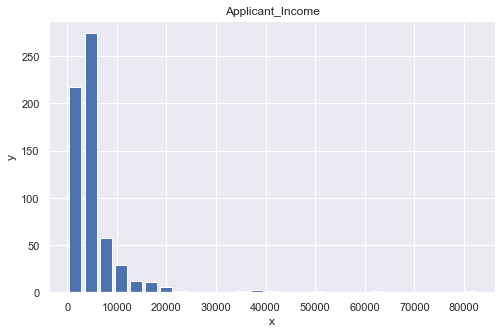

Coapplicant_Income
41667.0 0.0 1461.9322298850313


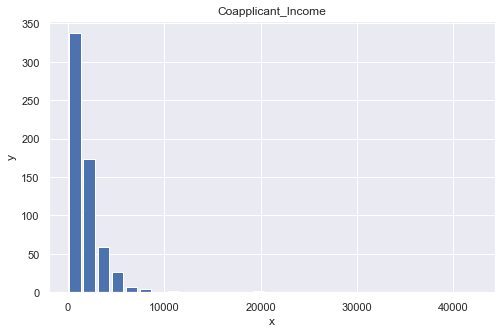

Loan_Amount
700.0 9.0 42.75750404560166


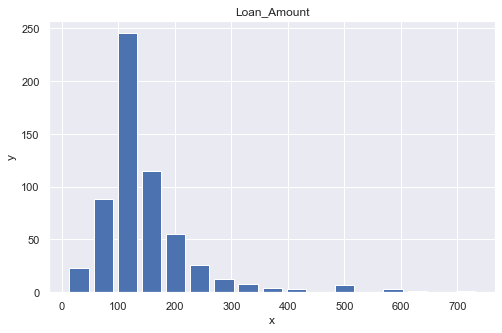

Loan_Amount_Term
480.0 12.0 32.5330601081423


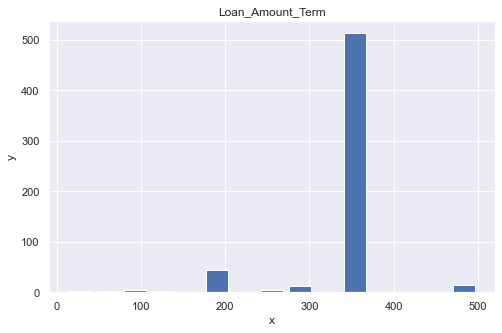

In [28]:
for cat in num_cats:
    print(cat)
    Max = np.max(data[cat])
    Min = np.min(data[cat])
    bin_width = np.std(data[cat])/2  #I did std dev/2 for slightly finer detail in histogram
    #alternative way to find width based on num bins desired
    #num_bins = 5  #what is a good way to select this automatically? 
    #bin_width =(Max - Min)/num_bins
    
    print(Max, Min, bin_width)
    bins=np.arange(Min, Max + bin_width, bin_width)
    x = data[cat]
    
    plt.hist(x, bins, histtype='bar', rwidth=0.8)
    plt.title(cat)
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.legend()
    plt.show()
    
    

### Conclusions on cts feature distributions

1. all exibit some sqew to the left and have a long right tail ... except
2. loan term is scattered and mostly (85%) concentrated at 360 months (30 yrs)
3. regrading imputing values for loan_amoun, probably avg is resonable,  \
and loan_amount_term, most common is reasonable (see cell below) - but might be more useful to keep NaN as predictor. 

In [29]:
##looks like most terms are one certain length ... yes, about 80-85% are 360 months (30 yrs)

data["Loan_Amount_Term"].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

#### Investigate NaN naive predictive strength for loan and loan term

In [30]:
##let's see how good a predictor or loan rejection, NaN in loan amount or loan term is ...

num_approved = data.loc[(data['Loan_Amount'].isnull()) & (data["Loan_Status"] == 1), "Loan_Status"].count()
num_cat_val = data.loc[(data['Loan_Amount'].isnull()) , 'Loan_Status'].count()
y_val = round(100*num_approved/num_cat_val, 1)
y_val

50.0

In [31]:

num_approved = data.loc[(data['Loan_Amount_Term'].isnull()) & (data["Loan_Status"] == 1), "Loan_Status"].count()
num_cat_val = data.loc[(data['Loan_Amount_Term'].isnull()) , 'Loan_Status'].count()
y_val = round(100*num_approved/num_cat_val, 1)
y_val

57.1

In [ ]:
# seems to be good predictor (base-line rate is 69%)

#### secondary question: are loan and loan_term NaN the same rows? (A below: no overlap)




In [32]:
A = set(data.loc[(data['Loan_Amount_Term'].isnull()) , 'Loan_Status'].index)
B =  set(data.loc[(data['Loan_Amount'].isnull()) , 'Loan_Status'].index)
print(len(A), len(B), len(A ^ B))  #symmetric diff


14 22 36


#### conclusion of 8.1 investigation:  create new category for this NaN in loan and loan term

In [33]:
##hm, creates another dummy var ... is it worth the complexity? Check the with and without performance later (in general feature
##selction process)

##consider making 3-4 bins with this variable, then unkown can be one of those ordinal cats.

data['Loan_Amount_Term_unk'] = 'No' #set default to 'No' then set a few to be 'Yes'
data['Loan_Amount_unk'] = 'No'  
data.loc[(data['Loan_Amount_Term'].isnull()) , 'Loan_Amount_Term_unk'] = 'Yes'
data.loc[(data['Loan_Amount'].isnull()) , 'Loan_Amount_unk'] = 'Yes'


In [34]:
#cursary check; note: I could and probably should make these data checks more rigorous 
#(create auxilary data2 ... compare index of new vals to old)

print(data[ 'Loan_Amount_unk'].value_counts())
print(data['Loan_Amount_Term_unk'].value_counts())  #matches the NaN counts .

No     592
Yes     22
Name: Loan_Amount_unk, dtype: int64
No     600
Yes     14
Name: Loan_Amount_Term_unk, dtype: int64


###  decision on NaN in cts features:

1. I have left the NaN values in LoanAmount and Loan_Amount_Term (if we uses np functions things will be calculated correctly)
2. I created two new categories for missing loan and loan term since these predict loan not approval \
at a rate (50-57%) that is lower than the base-line rate (69%) by a fair margin.

In [35]:
data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Applicant_Income', 'Coapplicant_Income',
       'Loan_Amount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Loan_Status', 'Loan_Amount_Term_unk', 'Loan_Amount_unk'],
      dtype='object')

## Now we compare cts-cts, cat-cat, cat-cts variables, especially with target.

## Question 9: Look at how target varies across each category value  
(note: NaN as 'unk' will also be looked at as a predictor)

In [36]:
##Here we calculate for each category value of rach category, what is the perecent of those people that get approved?
##the results are stored in a dictionary of the form dic[cat] = [[cat_val1, cat_val2, ...], [%approved1, %approved2, ....]]

cat_targ_dic = {}
for cat in cat_cats:
    cat_targ_dic[cat] = [[],[] ]
#first list will be cat_vals; second list will be in %approved



cat_values = []  #we want this and dictionary re-intialized to [] every time we run this cell, otherwise it keeps getting bigger! :-)
for cat in cat_cats: 
    cat_values = list(set(data[cat]))
    cat_targ_dic[cat][0] += cat_values #0 is for first entry of the tuple ([cat_values], [% approved]); we assign all the cat_vals at once here
    for cat_val in cat_values: 
        num_approved = data.loc[(data[cat] == cat_val) & (data["Loan_Status"] == 1), "Loan_Status"].count()
        num_cat_val = data.loc[(data[cat] == cat_val) , 'Loan_Status'].count()
        y_val = round(100*num_approved/num_cat_val, 1)
        cat_targ_dic[cat][1].append(y_val) #1 is for second entry of the tuple ([cat_values], [% approved]);
        
#why is Python being a wimp here?         
        

In [37]:
for cat in cat_cats:
    print(cat, cat_targ_dic[cat])

Gender [['Female', 'Male', 'unk'], [67.0, 69.3, 61.5]]
Married [['unk', 'No', 'Yes'], [100.0, 62.9, 71.6]]
Self_Employed [['unk', 'No', 'Yes'], [71.9, 68.6, 68.3]]
Property_Area [['Semiurban', 'Urban', 'Rural'], [76.8, 65.8, 61.5]]
Dependents [[0, 1, 2, 3, 'unk'], [69.0, 64.7, 75.2, 64.7, 60.0]]
Education [[0, 1], [61.2, 70.8]]
Credit_History [['unk', 'Yes', 'No'], [74.0, 79.6, 7.9]]


## Notes

#### not much predictive power
1. Self_Employed [['unk', 'No', 'Yes'], [71.9, 68.6, 68.3]]  --> no apparent predictive power
2. Gender [['Female', 'Male', 'unk'], [67.0, 69.3, 61.5]] , very slight; but 'unk' more significant (count = 13, 2%)

#### good predictors

1. Married [['unk', 'No', 'Yes'], [100.0, 62.9, 71.6]]
Married is pretty good predictor ('unk' 100% approval? check how many of those, ah ... only 3, ok)
2. Property_Area [['Semiurban', 'Urban', 'Rural'], [76.8, 65.8, 61.5]]
Semi-urban is way above base-line approval; urban, rural are below;
hypthosis: semi-urban is often suburbs; stable family and jobs?
3. Dependents [[0, 1, 2, 3, 'unk'], [69.0, 64.7, 75.2, 64.7, 60.0]] 
Dependents: 2 dependents is the sweet spot; otherwise 0 is about same as baseline
4. Education [[0, 1], [61.2, 70.8]] Education is decent predictor
5. Credit_History [['unk', 'Yes', 'No'], [74.0, 79.6, 7.9]]  is decent predictor (excelt 'unk' is suprsingly positive, keep eye out for other factors)

#### Note

There is no point in looking at accurcay as sole predictor because all cat_values preict approval = 1 (except Credit_History = "no") 

### Question 10: describe how target varies across each numerical variable (boxplot)

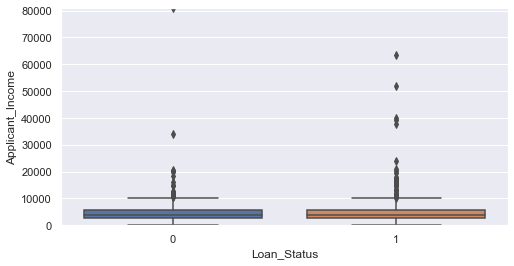

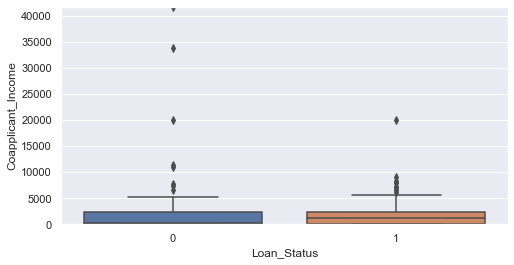

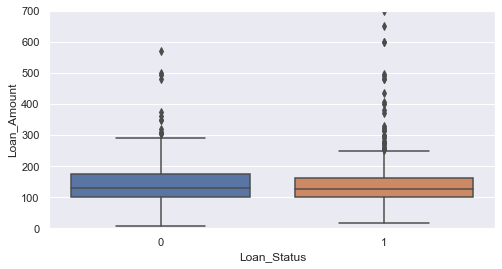

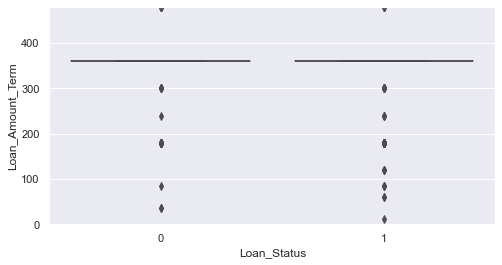

In [38]:
##source of data vis code: https://data.compass.lighthouselabs.ca/days/w03d3/activities/468

var = 'Loan_Status'
for cat in num_cats:
#cat = "Applicant_Income"
    #'GarageQual'
    f, ax = plt.subplots(figsize=(8, 4))
    Max = np.max(data[cat])
    data2 = data[[cat,var]]
    fig = sns.boxplot(x=var, y=cat, data=data2)
    fig.axis(ymin=0, ymax=Max)

### Conclusions

I don't see any significant patterns here; the average and variance is about the same across each category value ... \
One thing: high applicant incomes go with approval; but high co-applicant incomes seem to all be with not approved. Strange. 

In [ ]:
## Question 11: (cts-cat) take a look at how all cts variables vary over all categorical variables (box-plot)

<ipython-input-39-60ab5690b4eb>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(8, 4))


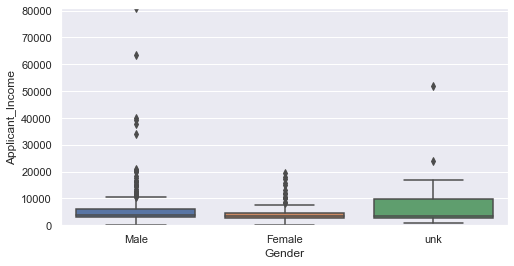

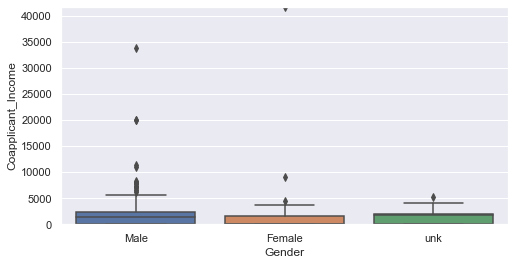

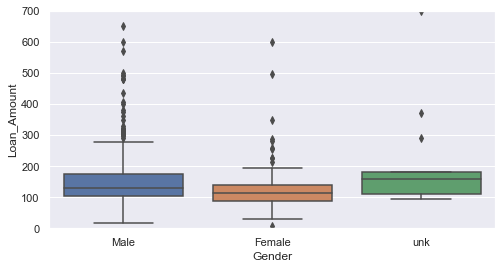

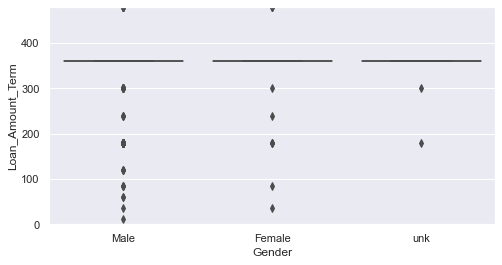

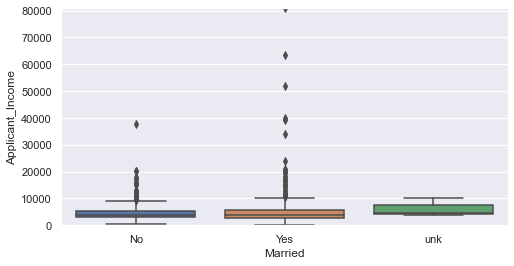

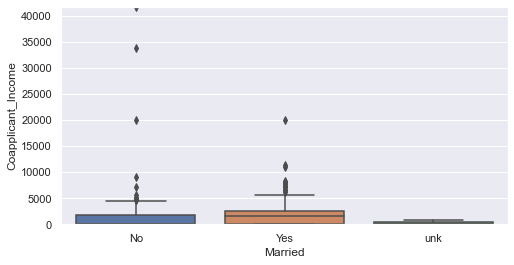

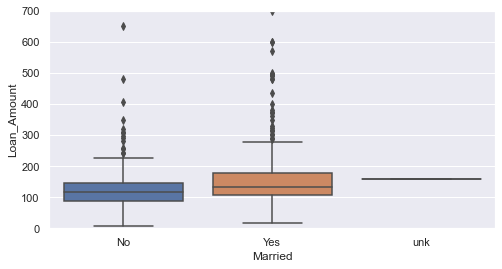

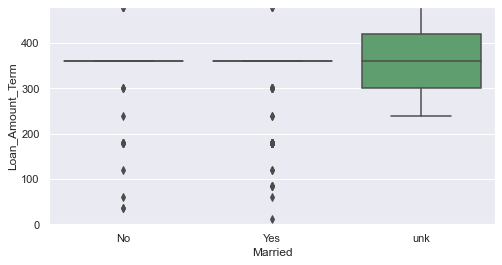

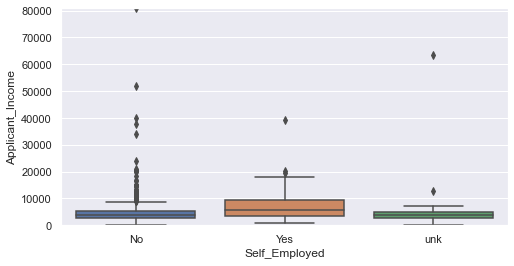

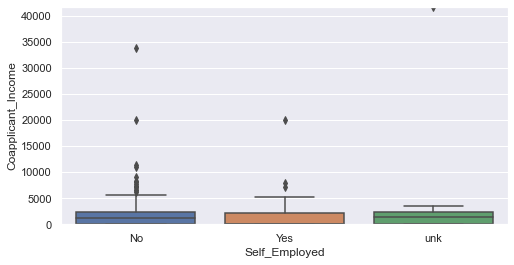

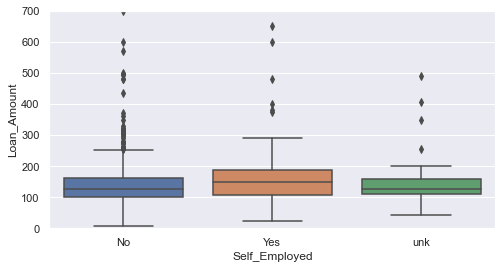

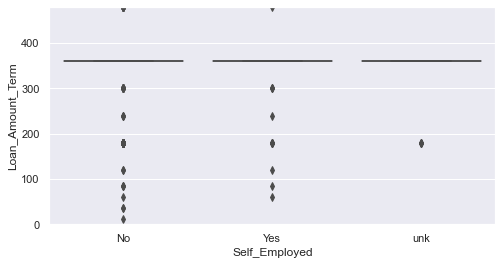

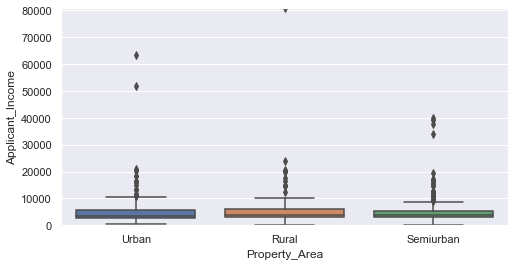

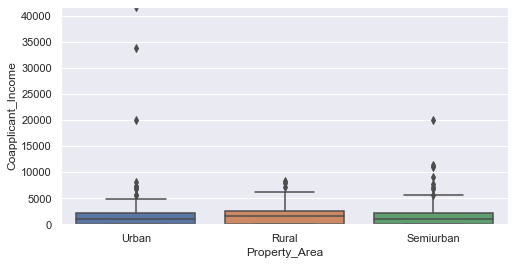

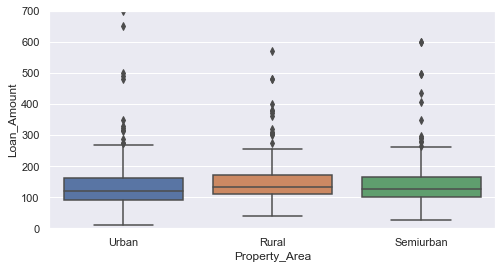

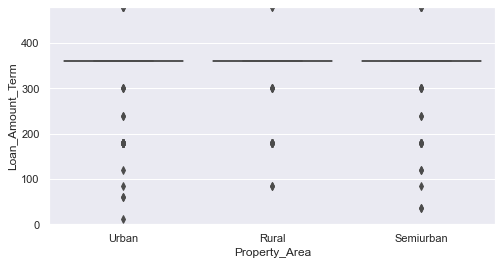

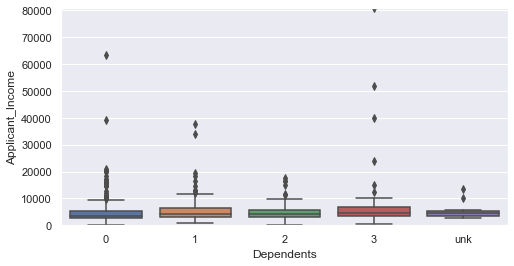

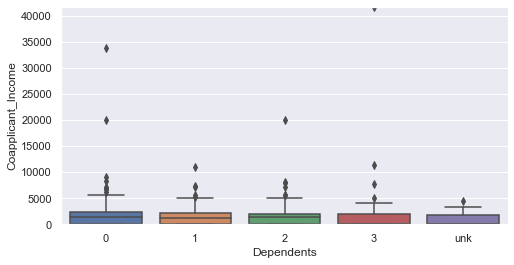

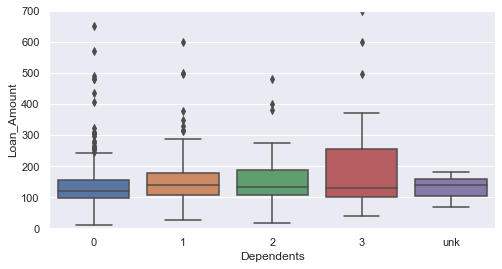

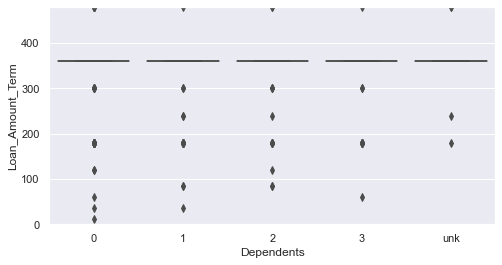

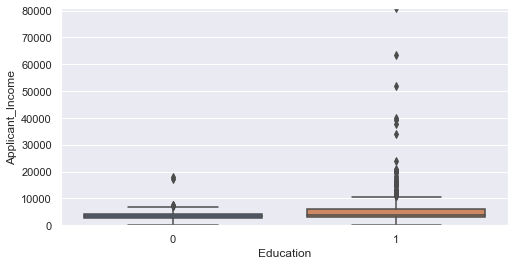

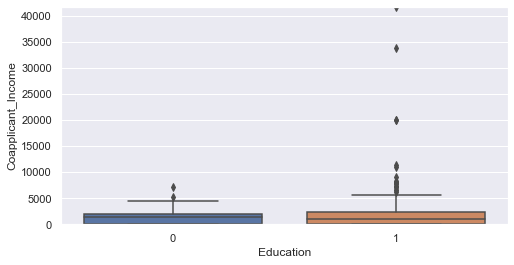

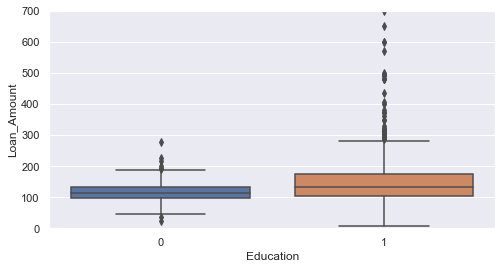

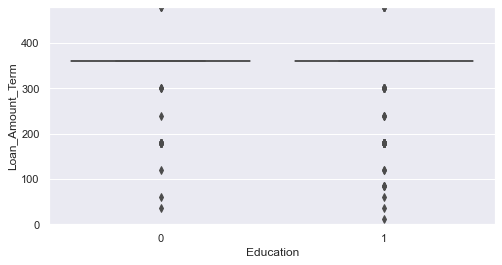

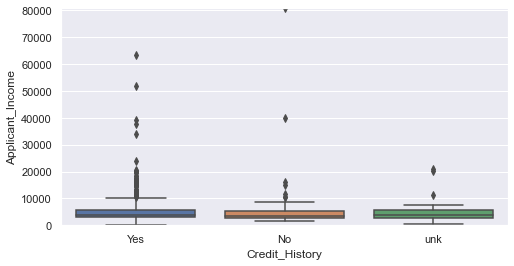

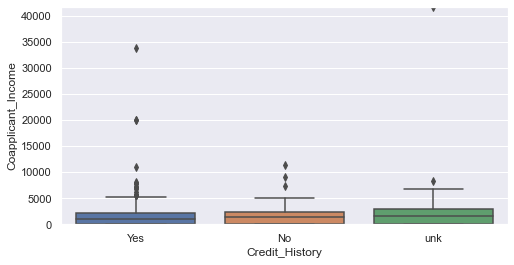

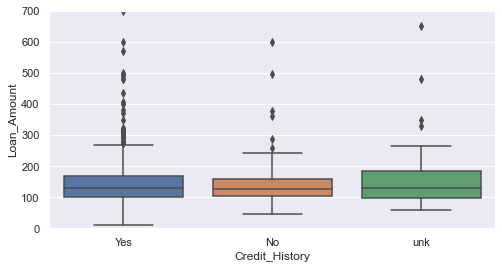

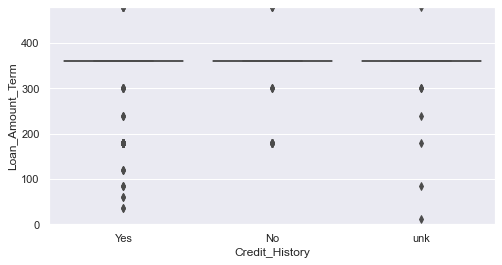

In [39]:
for var in cat_cats:
    for cat in num_cats:
        f, ax = plt.subplots(figsize=(8, 4))
        Max = np.max(data[cat])
        data2 = data[[cat,var]]
        fig = sns.boxplot(x=var, y=cat, data=data2)
        fig.axis(ymin=0, ymax=Max)
    

### Conclusions

I don't seea any significant patterns here ... similar avg and variance across the category values \
... some slightly interesting  variation in where the hight values are located ...

### Question 13. For cts-cts variables, look at the scatter-plot (scatter-matrix color coded by cat_target) and the correlation matrix, including target

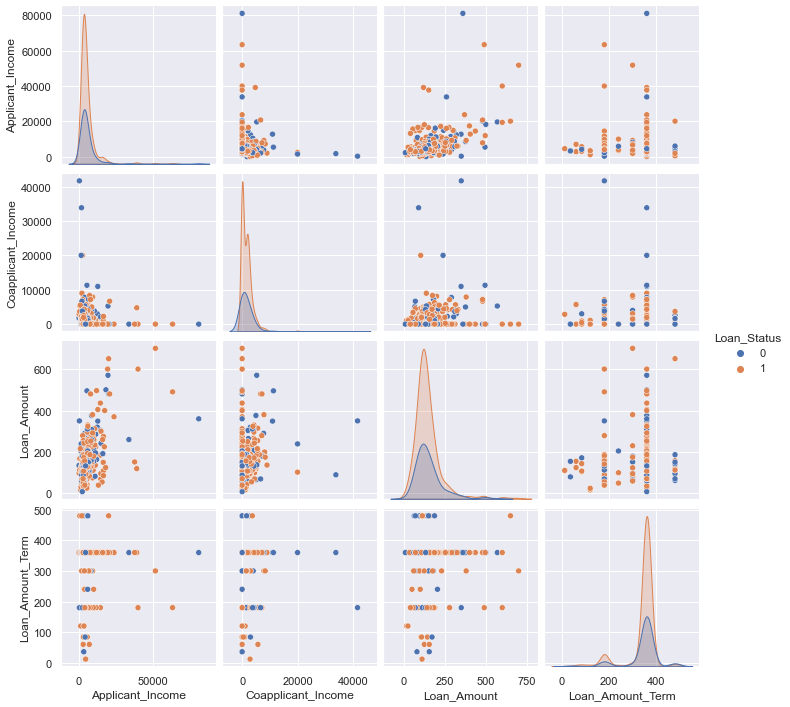

In [42]:
#source: https://dzone.com/articles/what-when-amp-how-of-scatterplot-matrix-in-python

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets

# Load iris dataset
#iris = datasets.load_iris()

# Create dataframe using IRIS dataset
#df = pd.DataFrame(iris.data)
# df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

#df['class'] = iris.target


df = data.loc[:, num_cats+target]  #load all numerical cats

# Create pairplot of all the variables with hue set to class

sns.pairplot(df, hue='Loan_Status')  
plt.show()




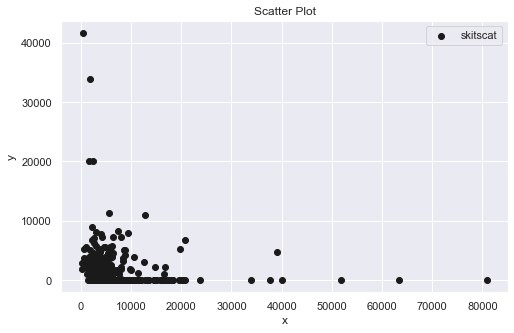

In [43]:
##matplot lib old school version ... looks the same 

# cts-cts; cts-target

##scatter plot
x = data['Applicant_Income']
y = data['Coapplicant_Income']


plt.scatter(x,y, label='skitscat', color='k')
plt.title('Scatter Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Now for the correlation matrix (numerical and heat map)

In [70]:
#data[target]

<AxesSubplot:>

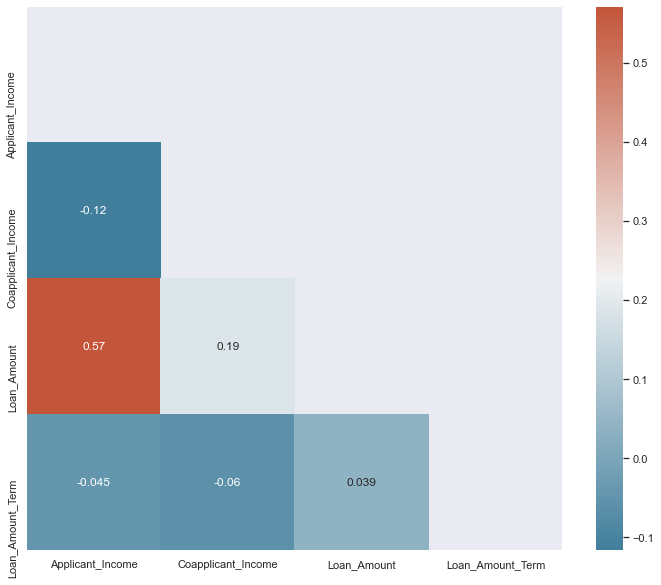

In [74]:
##source: https://vitalflux.com/correlation-heatmap-with-seaborn-pandas/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#
# Correlation between different variables
#
corr = data.loc[:,num_cats].corr()

# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

#### No interesting correlations; things are uncorelated except loan amount and income ... why is it ignoring target? 

### Question 14. Compare cat-cat variables by making stacked bar charts (percent contribution of cat1 to cat_val2)

In [ ]:
len(data['Gender'])

In [ ]:
round(124.374,1)

In [ ]:
def round(x,n=1): 
    m = int(x)
    p = len(str(m))
    #x = 0.673  or x = 0.0672, or 0.00453 or 0.000456
    y = 100*x
    if y < 1:  #0.256 or 0.0778
        return int(y*10)

In [47]:

cat1_cat2_dic = {}
for cat1 in cat_cats:
    for cat2 in cat_cats: 
        cat_values1 = list(set(data[cat1]))
        cat_values2 = list(set(data[cat2]))
        for cat_val1 in cat_values1:
            for cat_val2 in cat_values2:
                if cat1 != cat2:
                    total_in_cat_val2 = data.loc[data[cat2] == cat_val2, cat2].count()
                    total_cat_val1_in_cat_val2 = data.loc[(data[cat1] == cat_val1)&(data[cat2] == cat_val2), cat2].count()
                    perc_cat_val1_of_cat_val2 = round(100*(total_cat_val1_in_cat_val2 /total_in_cat_val2), 1)
                    cat1_cat2_dic[(cat1, cat2, cat_val1, cat_val2)] = perc_cat_val1_of_cat_val2

In [59]:
#take a peak ... looks good, looks like it's adding up to 100% in eacg cat_val2
cat_cats_small = ["Property_Area", "Dependents"] #temporary restricted set

for cat1 in cat_cats_small:
    for cat2 in cat_cats: 
        if cat1 != cat2:
            cat_values1 = list(set(data[cat1]))
            cat_values2 = list(set(data[cat2]))
            for cat_val2 in cat_values2:
                for cat_val1 in cat_values1:
                    print(cat1, cat2, cat_val1, cat_val2,cat1_cat2_dic[(cat1, cat2, cat_val1, cat_val2)])

Property_Area Dependents Semiurban 0 37.7
Property_Area Dependents Urban 0 30.7
Property_Area Dependents Rural 0 31.6
Property_Area Dependents Semiurban 1 39.2
Property_Area Dependents Urban 1 40.2
Property_Area Dependents Rural 1 20.6
Property_Area Dependents Semiurban 2 36.6
Property_Area Dependents Urban 2 34.7
Property_Area Dependents Rural 2 28.7
Property_Area Dependents Semiurban 3 39.2
Property_Area Dependents Urban 3 25.5
Property_Area Dependents Rural 3 35.3
Property_Area Dependents Semiurban unk 40.0
Property_Area Dependents Urban unk 46.7
Property_Area Dependents Rural unk 13.3
Dependents Property_Area 0 Semiurban 55.8
Dependents Property_Area 1 Semiurban 17.2
Dependents Property_Area 2 Semiurban 15.9
Dependents Property_Area 3 Semiurban 8.6
Dependents Property_Area unk Semiurban 2.6
Dependents Property_Area 0 Urban 52.5
Dependents Property_Area 1 Urban 20.3
Dependents Property_Area 2 Urban 17.3
Dependents Property_Area 3 Urban 6.4
Dependents Property_Area unk Urban 3.5
Depe

In [45]:
#test for two fixed categories

cat1 = "Property_Area"
cat2 = "Dependents"
cat_vals1 = list(set(data[cat1]))
cat_vals2 = list(set(data[cat2]))
cat_val1 = cat_vals1[1]
cat_val2 = cat_vals2[0]
print(cat1, cat2, cat_val1, cat_val2)


Property_Area Dependents Urban 0


In [46]:
##looks good, each one sums to 100%

for cat_val2 in cat_vals2:
    for cat_val1 in cat_vals1:
        total_in_cat_val2 = data.loc[data[cat2] == cat_val2, cat2].count()
        total_cat_val1_in_cat_val2 = data.loc[(data[cat1] == cat_val1)&(data[cat2] == cat_val2), cat2].count()
        perc_cat_val1_of_cat_val2 = round(100*(total_cat_val1_in_cat_val2/total_in_cat_val2), 1)
        print( total_in_cat_val2,
        total_cat_val1_in_cat_val2,
        perc_cat_val1_of_cat_val2)

345 130 37.7
345 106 30.7
345 109 31.6
102 40 39.2
102 41 40.2
102 21 20.6
101 37 36.6
101 35 34.7
101 29 28.7
51 20 39.2
51 13 25.5
51 18 35.3
15 6 40.0
15 7 46.7
15 2 13.3


In [62]:
##make pivot table, make stacked graph

# source for df ---> pivot table ---> graph  https://pstblog.com/2016/10/04/stacked-charts
## example I'm trying to do - this is helpful to stare at! (first stacked one) https://www.saedsayad.com/categorical_categorical.htm

##instead of plotting graphs right away I make a dictionary of pivot tables and make sure they are correct when graphed (de-bugging below)
##then a couple cells down I print all the stacked graphs using the dictionary

#colors = ["#006D2C", "#31A354","#74C476"]
#colors = ['r','b','g']
pivot_df_dic = {}
for cat1 in cat_cats:
    for cat2 in cat_cats: 
        cat_vals1 = list(set(data[cat1]))
        cat_vals2 = list(set(data[cat2]))
        if cat1 != cat2:
            column_names = [cat1, cat2, 'percent_cat1_over_cat2']
            df = pd.DataFrame(columns = column_names)  #this df is really df_cat1_cat2 it depends on fixed cat1, cat2
            for cat_val1 in cat_vals1:
                for cat_val2 in cat_vals2:
                    new_row = {cat1: cat_val1, cat2: cat_val2, 'percent_cat1_over_cat2': cat1_cat2_dic[(cat1, cat2, cat_val1, cat_val2)] }
                    df= df.append(new_row, ignore_index=True)
                    pivot_df_dic[cat1,cat2] = df.pivot(index=cat2, columns=cat1, values='percent_cat1_over_cat2')
            #pivot_df.plot.bar(stacked=True, figsize=(4,3))


   Property_Area Dependents  percent_cat1_over_cat2
0      Semiurban          0                    37.7
1      Semiurban          1                    39.2
2      Semiurban          2                    36.6
3      Semiurban          3                    39.2
4      Semiurban        unk                    40.0
5          Urban          0                    30.7
6          Urban          1                    40.2
7          Urban          2                    34.7
8          Urban          3                    25.5
9          Urban        unk                    46.7
10         Rural          0                    31.6
11         Rural          1                    20.6
12         Rural          2                    28.7
13         Rural          3                    35.3
14         Rural        unk                    13.3
Property_Area  Rural  Semiurban  Urban
Dependents                            
0               31.6       37.7   30.7
1               20.6       39.2   40.2
2           

<AxesSubplot:xlabel='Dependents'>

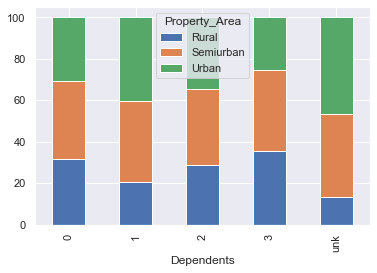

In [56]:
##de-bugging, my stacked bar charts should have all bars total lengh = 100 but they were varrying.
##simple fix  index = cat2 because we are slicing cat1 into percentages, over fixed cat2

cat1 = "Property_Area"
cat2 = "Dependents"
cat_vals1 = list(set(data[cat1]))
cat_vals2 = list(set(data[cat2]))
column_names = [cat1, cat2, 'percent_cat1_over_cat2']
df = pd.DataFrame(columns = column_names)
for cat_val1 in cat_vals1:
    for cat_val2 in cat_vals2:
        new_row = {cat1: cat_val1, cat2: cat_val2, 'percent_cat1_over_cat2': cat1_cat2_dic[(cat1, cat2, cat_val1, cat_val2)] }
        df= df.append(new_row, ignore_index=True)
        #print(df)
print(df)
pivot_df = df.pivot(index=cat2, columns=cat1, values='percent_cat1_over_cat2')  #simple fix --> index = cat2
print(pivot_df)
pivot_df.plot.bar(stacked=True, figsize=(6,4))

/Users/joejohns/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


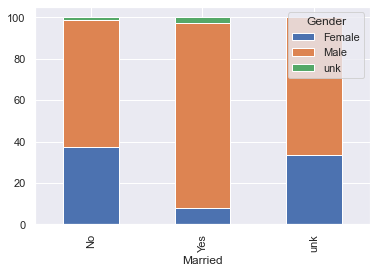

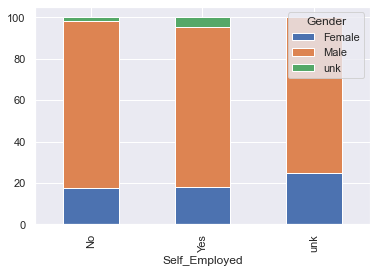

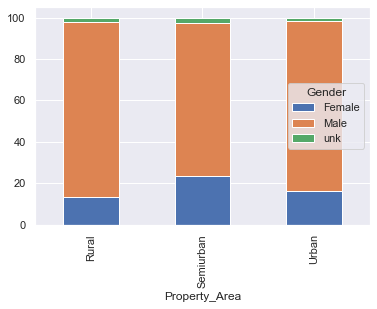

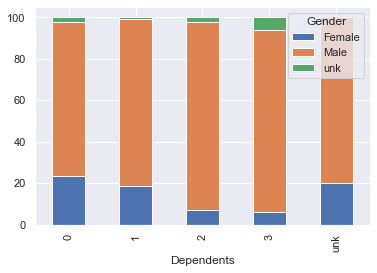

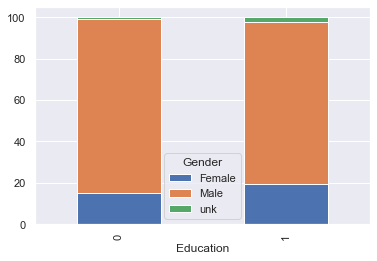

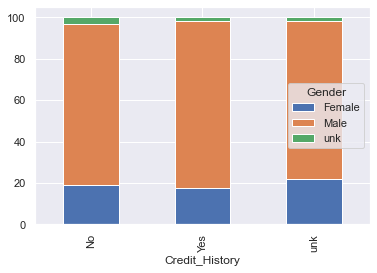

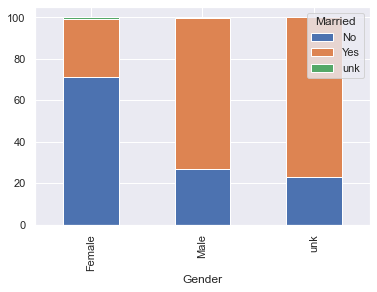

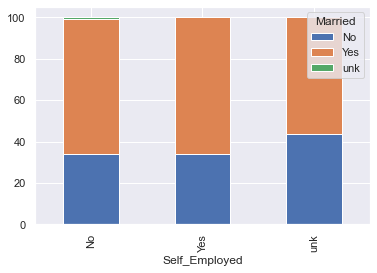

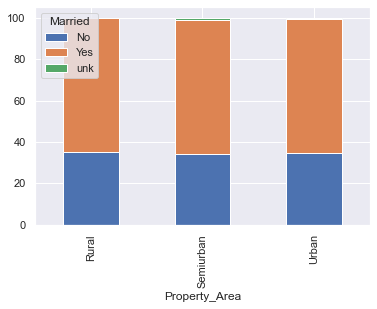

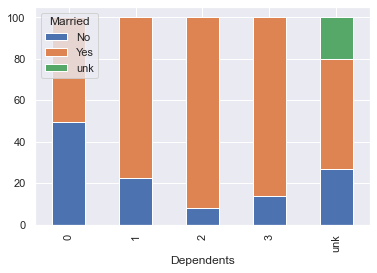

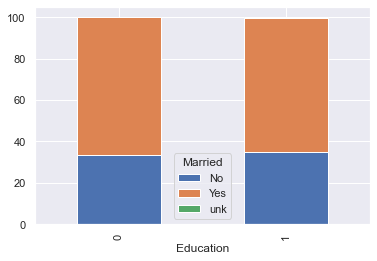

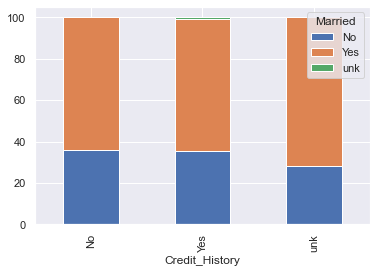

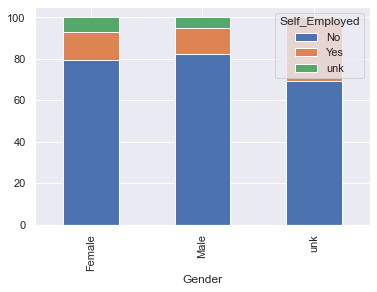

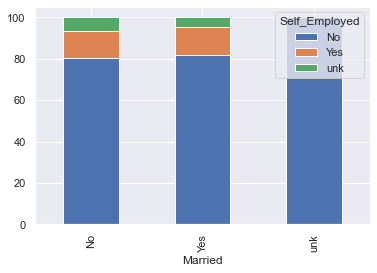

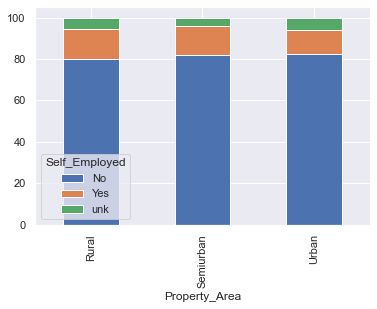

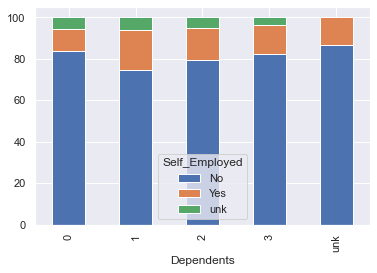

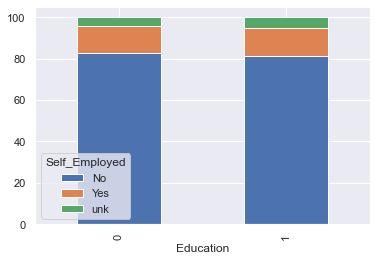

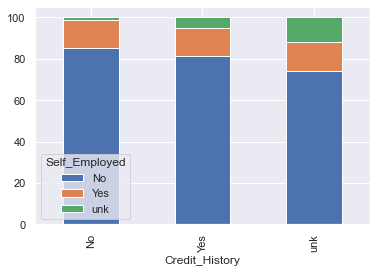

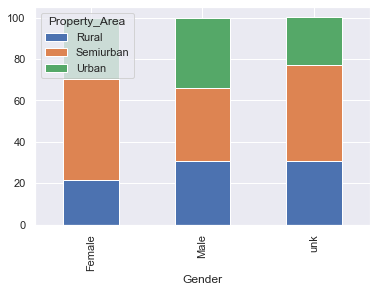

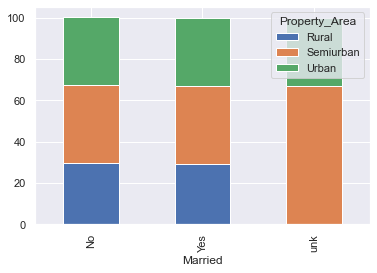

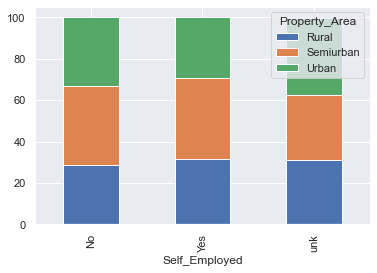

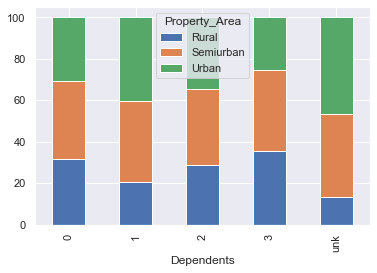

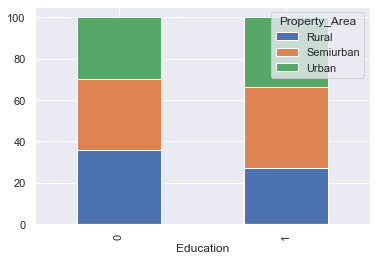

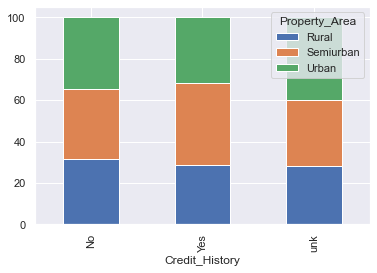

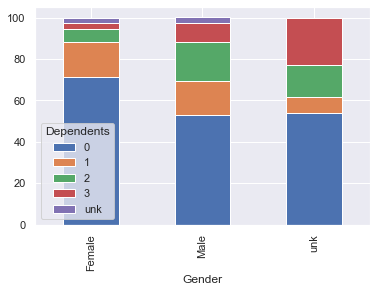

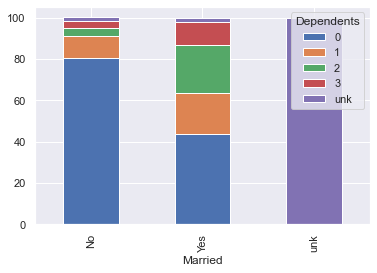

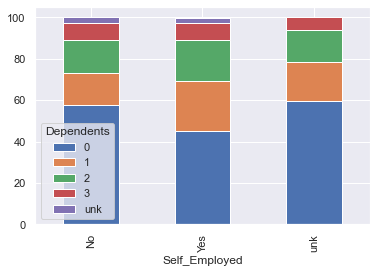

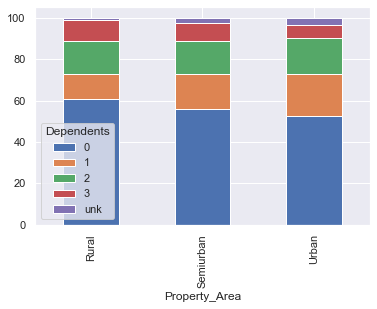

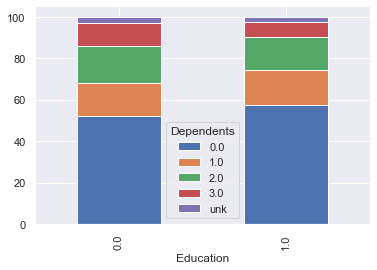

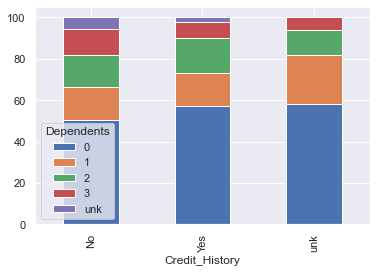

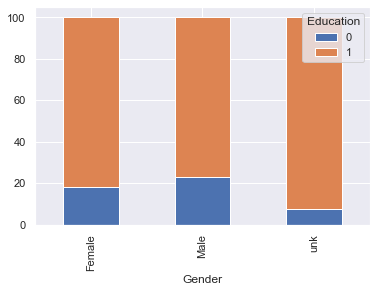

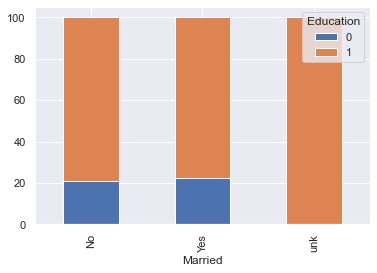

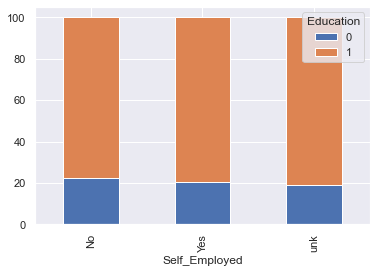

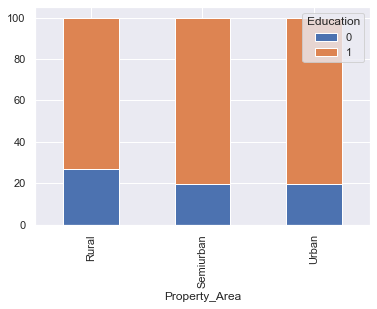

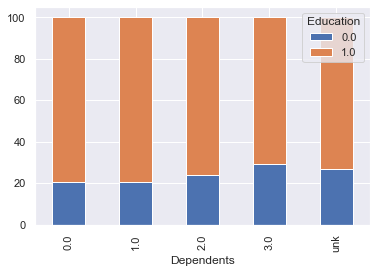

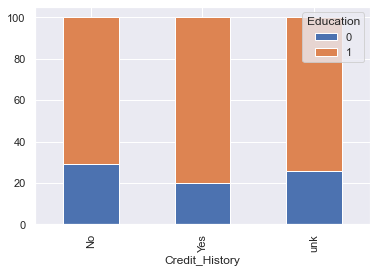

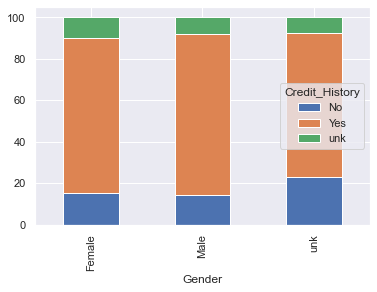

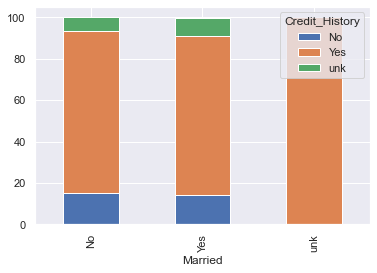

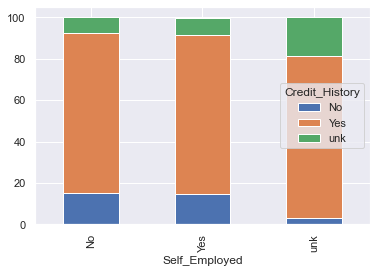

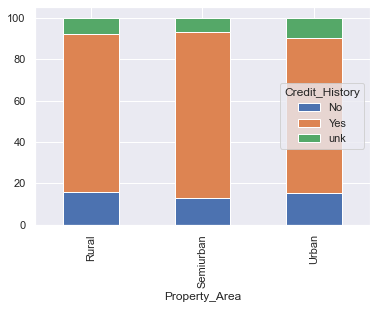

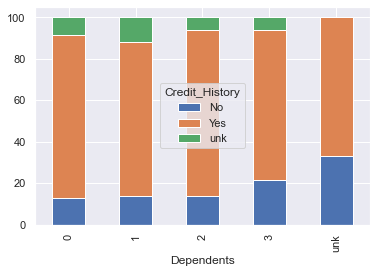

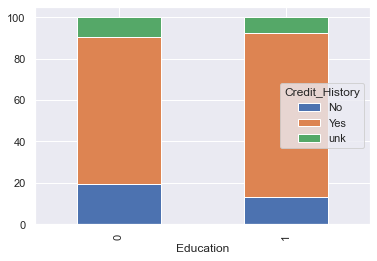

In [63]:
##print all the stacked graphs

for cat1 in cat_cats:
    for cat2 in cat_cats: 
        if cat1 != cat2: 
            pivot_df_dic[cat1,cat2].plot.bar(stacked=True, figsize=(6,4))

## Not sure what I can learn here ... inspect more closely later ... Is their reduncy?

### Below is beginning of turning the numerical distributions of cat vals into nice graphs

In [ ]:
###here we are looking into turning all the category distributions into nice bar graphs
## the one below is too big ... target is: make several small sub-graphs inside of 2 plots

##reference: https://medium.com/@The_Gambitier/matplotlib-essentials-e376ed954201

import matplotlib as mpl
import matplotlib.pyplot as plt

#Setting Styles
#We will use the `plt.style` directive to choose appropriate aesthetic styles for our figures.
# Setting Styles

plt.style.use('classic')

In [ ]:

axes = plt.axes()
axes.set_ylim([0, 100])

##let me change the x-vals to more human -friendly:

L = [ 'does not meet', 'does meet guidelines', 'Not available']

plt.bar(L,y) #label= 'Example one')
#plt.bar([2,4,6,8,10],[8,6,2,5,6], label= 'Example two',color='g')
#plt.legend()
plt.title('Percent approved by Credit Rating')
plt.xlabel('Credit rating meets approval?') # = -1, 0, 1 = NAN, no, yes')
plt.ylabel('Percent_approved')
plt.show()

In [ ]:
##can we do one big plot?
figure2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
                                        
ax1.plot(x1,y1)
ax2.plot(x2,y2)
ax3.plot(x3,y3)
ax4.plot(x4,y4)